# Text box region segmentation

Region segmentation test with OpenCV

## Code

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def find_text_boxes(img_path):
    image = cv2.imread(img_path)
    assert image is not None, "file could not be read"
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    markers = cv2.connectedComponents(thresh)[1]
    
    total_pixels = image.size
    
    segmented_regions = []
    
    for label in np.unique(markers):
        if label == -1:
            continue  # Skip the background
    
        mask = np.zeros_like(gray, dtype=np.uint8)
        mask[markers == label] = 255
    
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        non_black_pixels = cv2.countNonZero(mask)
        percentage_non_black = (non_black_pixels / total_pixels) * 100
    
        # Check if the region has more than 0.3% non-black pixels
        if percentage_non_black > 0.3:
    
            # create new image to illustrate bounding boxes
            region_image = np.zeros_like(image, dtype=np.uint8)
            cv2.drawContours(region_image, contours, -1, (0, 255, 0), thickness=cv2.FILLED)
            
            # save coordinates
            (x, y, width, height) = cv2.boundingRect(contours[0])
            if width > 5 and height > 5:
                # show image
                plt.imshow(region_image)
                plt.show()
                
                added = False
                for other_region in segmented_regions:
                    if other_region[0][0] == x:
                        for subregion in other_region:
                            if subregion[1] + subregion[3] in range(y - 10, y + 10):
                                other_region.append((x, y, width, height))
                                added = True
                                break
                if not added:
                    segmented_regions.append([(x, y, width, height)])

    return segmented_regions

In [3]:
def plot_regions(segmented_regions, img_path):
    image = cv2.imread(img_path)
    for region in segmented_regions:
        print("New region")
        for (x, y, w, h) in region:
            cropped_image = image[y:y+h, x:x+w]
            plt.imshow(cropped_image)
            plt.show()

## Examples

### Example 1

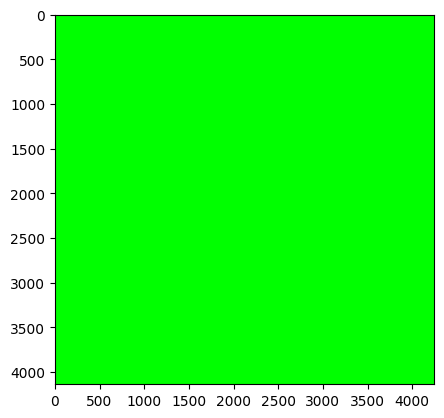

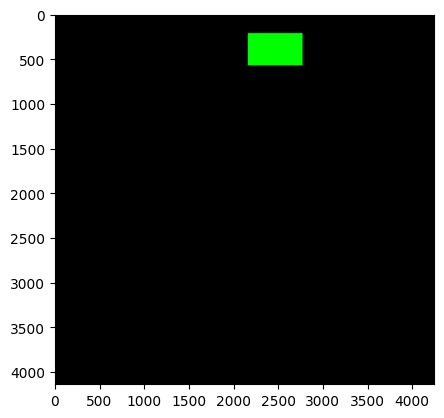

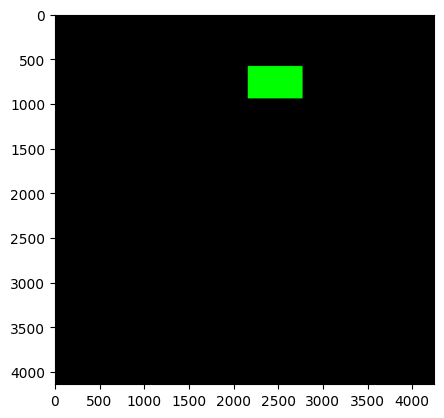

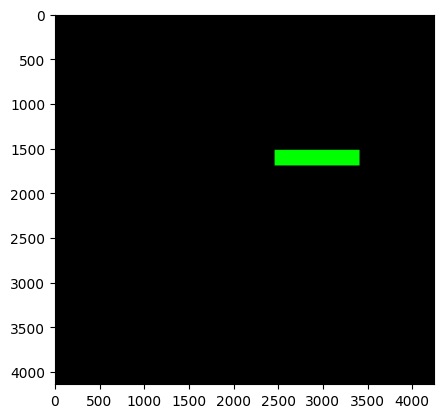

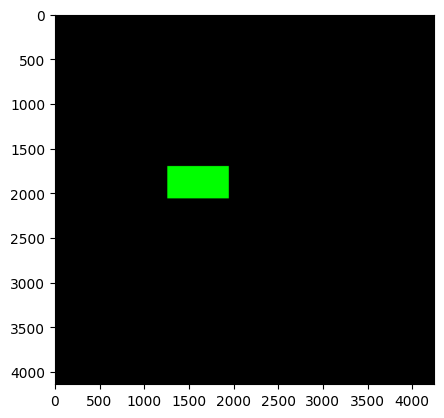

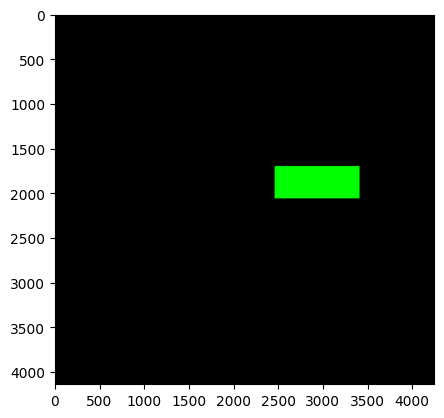

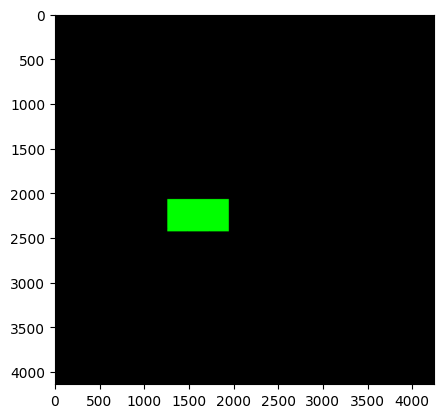

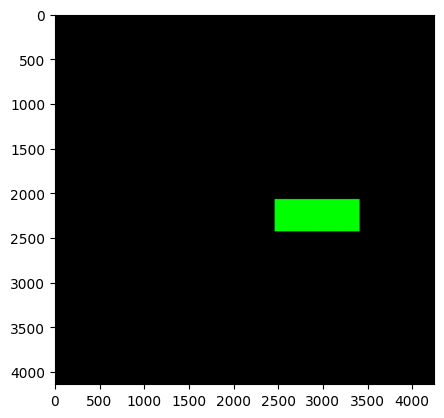

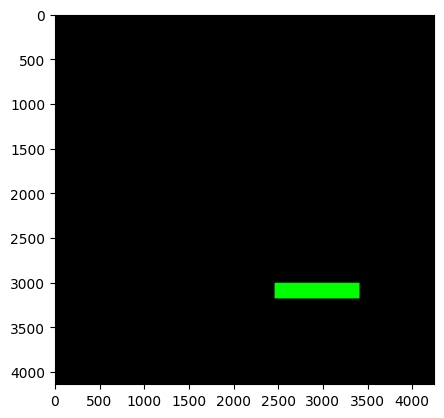

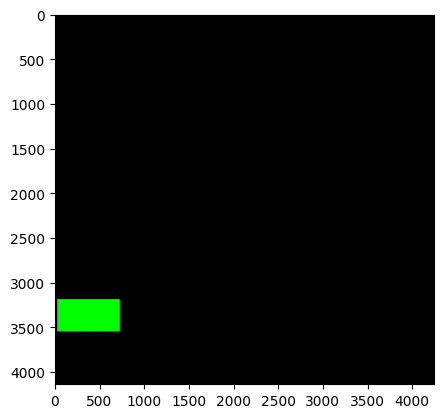

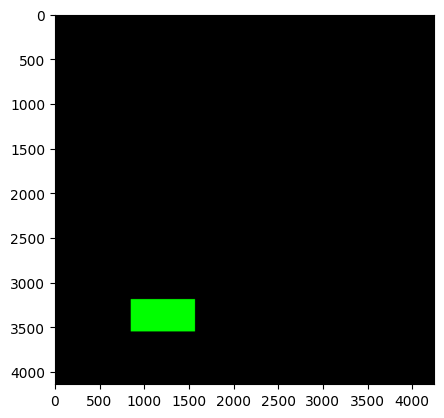

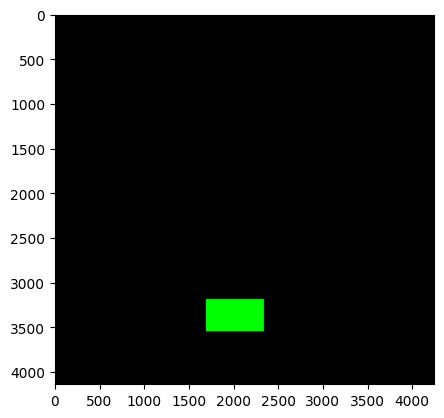

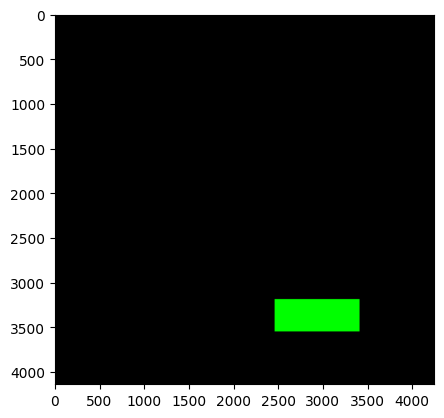

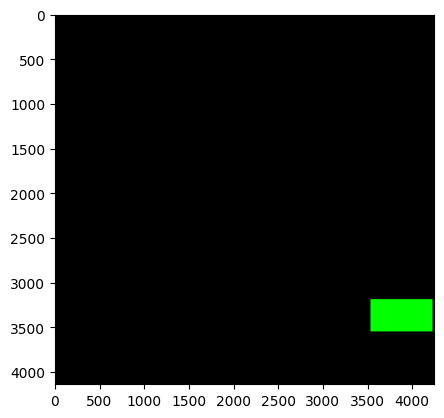

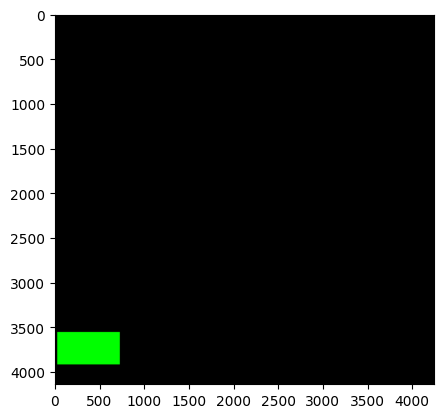

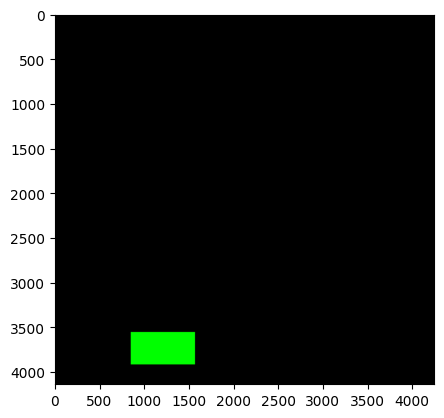

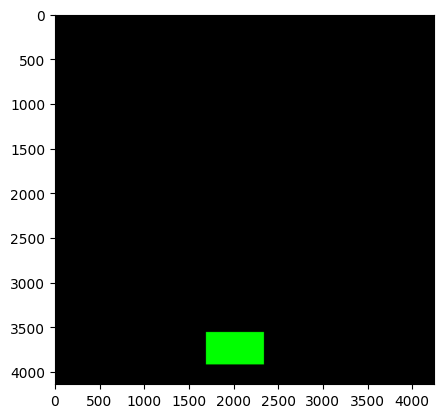

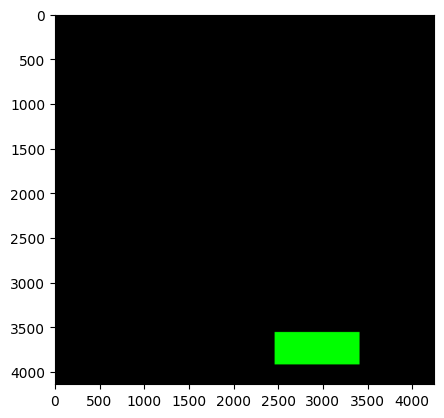

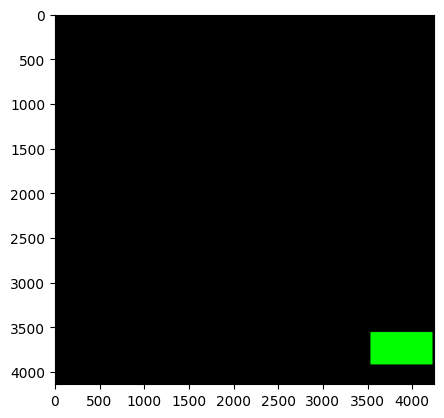

New region


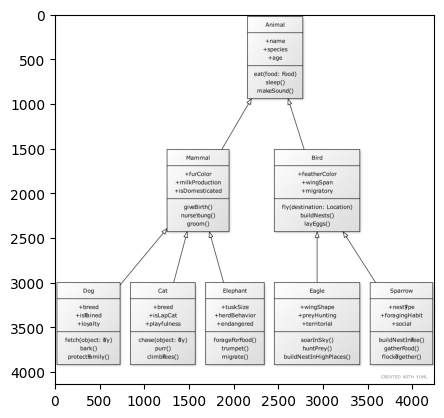

New region


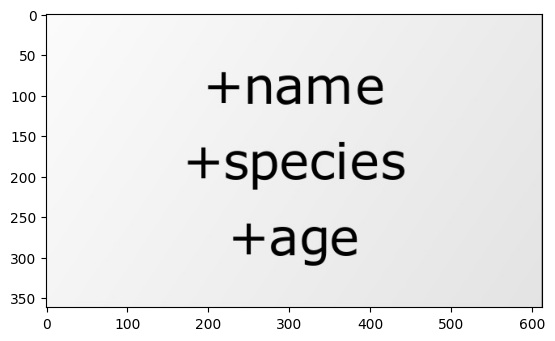

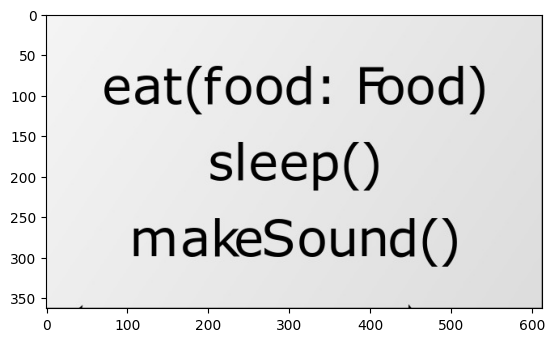

New region


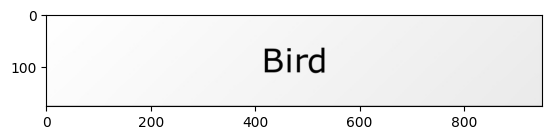

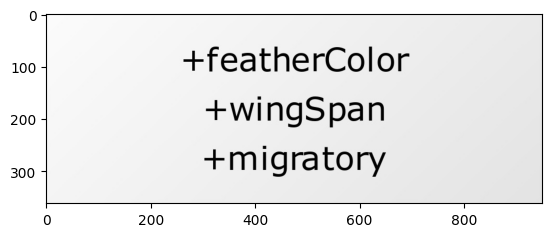

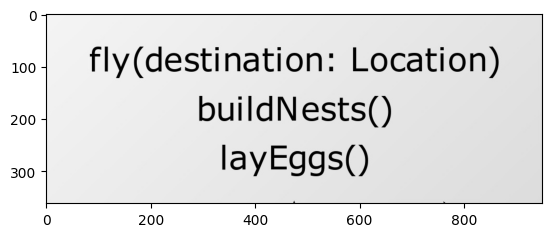

New region


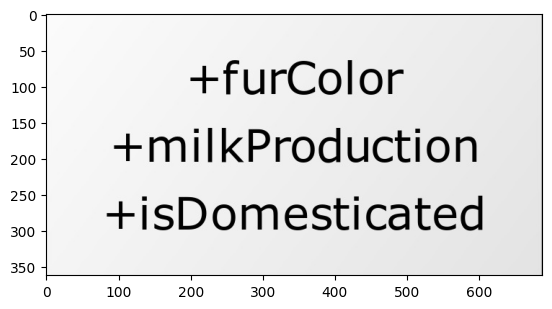

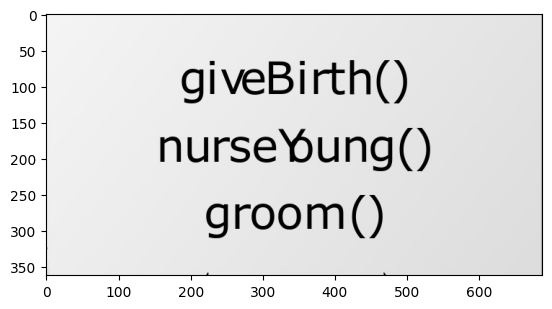

New region


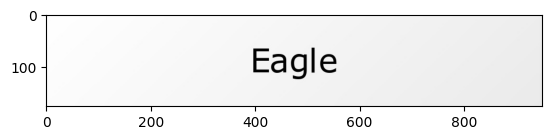

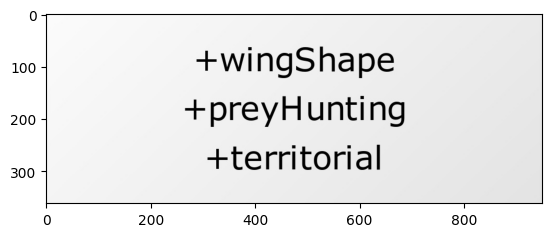

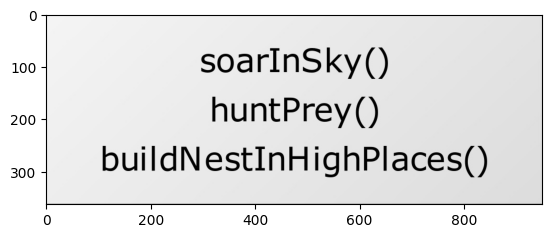

New region


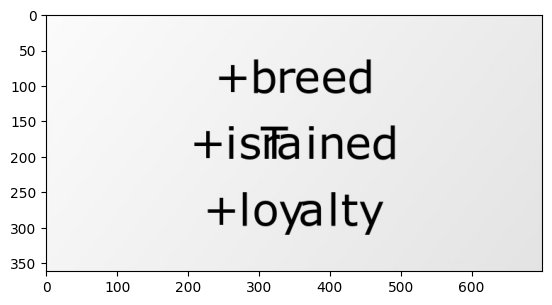

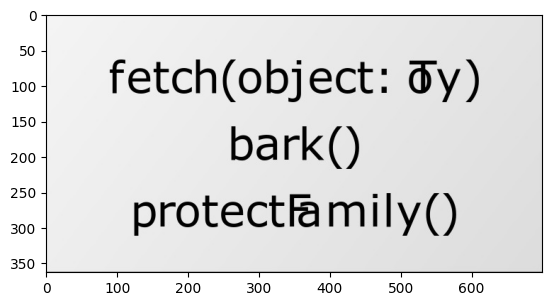

New region


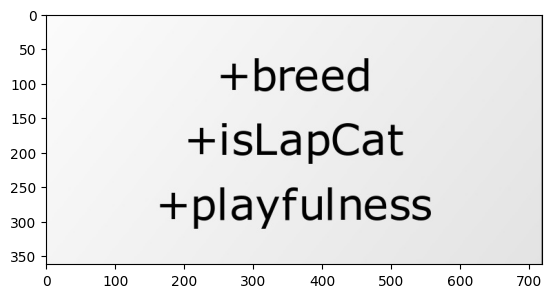

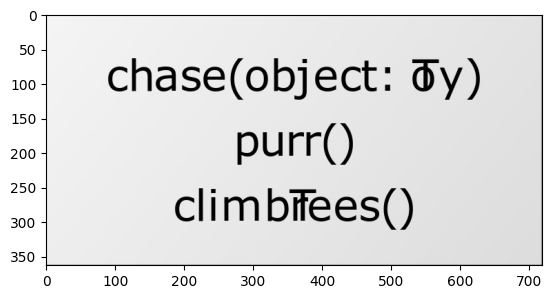

New region


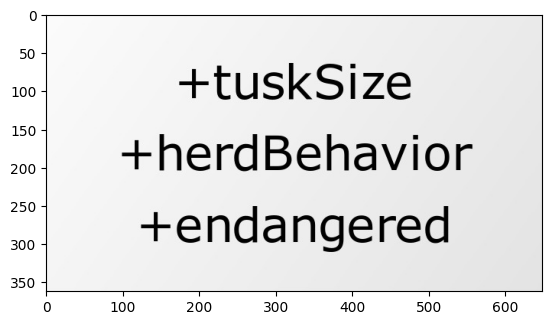

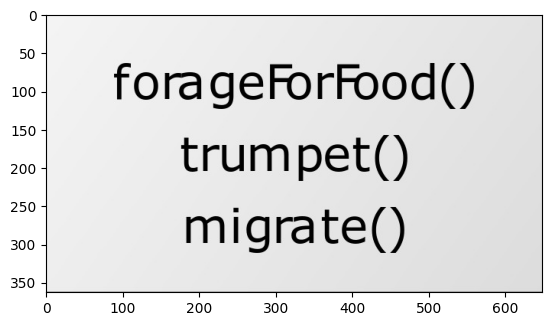

New region


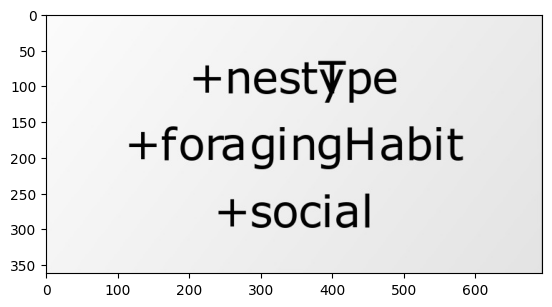

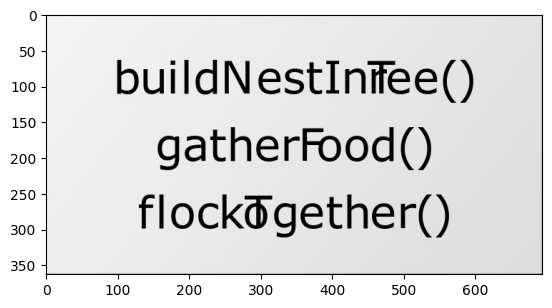

In [4]:
img_path_1 = 'diagrams/animal_subclasses.jpg'
text_box_1 = find_text_boxes(img_path_1)
plot_regions(text_box_1, img_path_1)

### Example 2

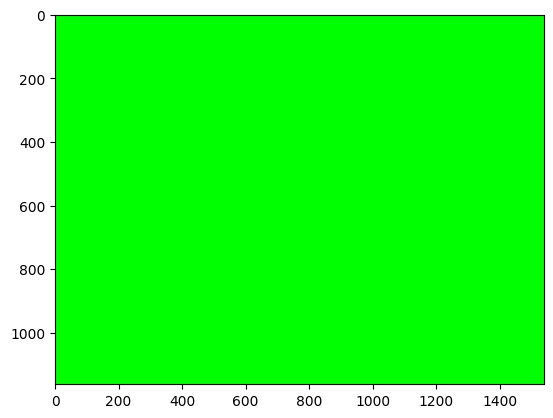

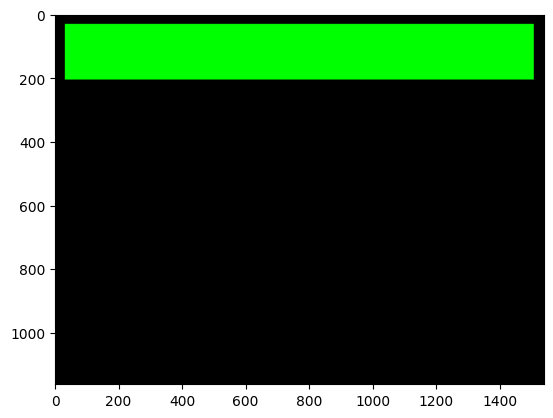

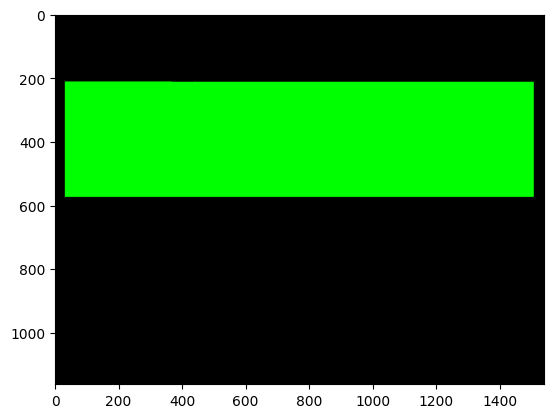

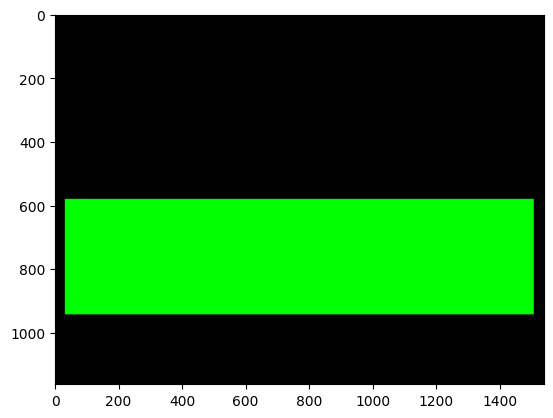

New region


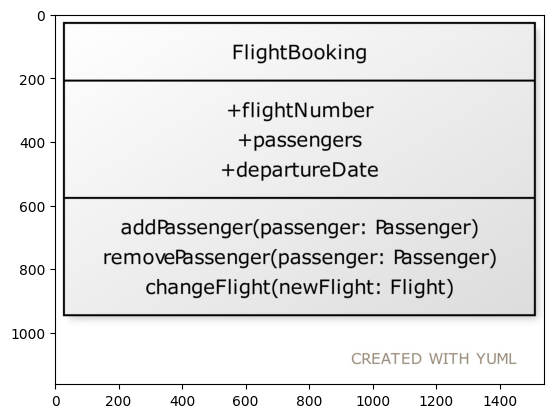

New region


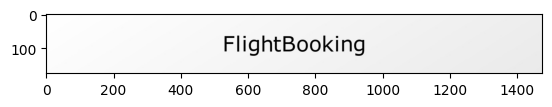

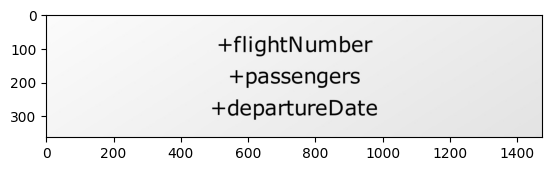

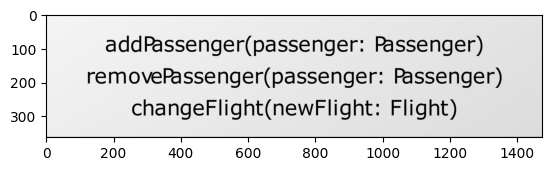

In [5]:
img_path_2 = 'diagrams/flight_booking.jpg'
text_box_2 = find_text_boxes(img_path_2)
plot_regions(text_box_2, img_path_2)

# OCR

In [6]:
import pytesseract

In [7]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Work\Uni\Artificial_intelligence\project\UML-to-Code\tesseract\tesseract.exe'

In [8]:
from PIL import Image

print(pytesseract.image_to_string(Image.open(img_path_2)))

FlightBooking

+flightNumber
+passengers
+departureDate

addPassenger(passenger: Passenger)
removePassenger(passenger: Passenger)
changeFlight(newFlight: Flight)

CREATED WITH YUML


# Segmentation + OCR

In [9]:
def get_class_text(img_path):
    def segment(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        markers = cv2.connectedComponents(thresh)[1]
        
        total_pixels = image.size
        
        segmented_regions = []
        
        for label in np.unique(markers):
            if label == -1:
                continue  # Skip the background
        
            mask = np.zeros_like(gray, dtype=np.uint8)
            mask[markers == label] = 255
        
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            non_black_pixels = cv2.countNonZero(mask)
            percentage_non_black = (non_black_pixels / total_pixels) * 100
        
            # Check if the region has more than 0.3% non-black pixels
            if percentage_non_black > 0.3:
                
                # save coordinates
                (x, y, width, height) = cv2.boundingRect(contours[0])
                if width > 5 and height > 5:
                    
                    added = False
                    for other_region in segmented_regions:
                        if other_region[0][0] == x:
                            for subregion in other_region:
                                if subregion[1] + subregion[3] in range(y - 10, y + 10):
                                    other_region.append((x, y, width, height))
                                    added = True
                                    break
                    if not added:
                        segmented_regions.append([(x, y, width, height)])

        segmented_regions.pop(0) # remove the whole diagram
        return segmented_regions
    
    text = ''
    image = cv2.imread(img_path)
    segmented_regions = segment(image)
    for region in segmented_regions:
        for (x, y, w, h) in region:
            cropped_image = image[y:y+h, x:x+w]
            text += pytesseract.image_to_string(cropped_image) + '\n'
    return text

In [10]:
print(get_class_text(img_path_2))

FlightBooking

+flightNumber
+passengers
+departureDate

addPassenger(passenger: Passenger)
removePassenger(passenger: Passenger)
changeFlight(newFlight: Flight)


# Extract class parameters

In [11]:
text = get_class_text(img_path_2)

In [20]:
def get_parameters(text):
    class_params = {}
    
    text = text.splitlines()
    text = [line for line in text if line != '']
    
    class_params['name'] = text[0]
    class_params['attributes'] = []
    class_params['methods'] = []
    
    for field in text:
        if field[0] == '+':
            class_params['attributes'].append(field[1:])
        elif '(' in field:
            class_params['methods'].append(field)
    
    return class_params

In [21]:
get_parameters(text)

{'name': 'FlightBooking',
 'attributes': ['flightNumber', 'passengers', 'departureDate'],
 'methods': ['addPassenger(passenger: Passenger)',
  'removePassenger(passenger: Passenger)',
  'changeFlight(newFlight: Flight)']}